In [11]:
import pandas as pd
import warnings
from datetime import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


warnings.filterwarnings("ignore")

In [1]:
# loading in the data

TAXI_FILES = [
                './data/yellow_tripdata_2019-05.csv',\
                './data/yellow_tripdata_2019-06.csv', \
                './data/yellow_tripdata_2019-07.csv', \
                './data/green_tripdata_2019-05.csv', \
                './data/green_tripdata_2019-06.csv', \
                './data/green_tripdata_2019-07.csv'
]

In [3]:
full_taxi_data_df = pd.DataFrame()
chosen_taxi_files = TAXI_FILES
parse_date_columns_yellow = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
parse_date_columns_green = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']
data_types = {
                'store_and_fwd_flag': str,
}


# append all dataframe to a single dataframe with flags for green or yellow taxi             
for taxi_file in chosen_taxi_files:

    # for yellow taxi data
    if 'yellow' in taxi_file:
        df = pd.read_csv(taxi_file, dtype=data_types, parse_dates= parse_date_columns_yellow, dayfirst=True)
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime": "dropoff_datetime"}, inplace=True)
        df['is_yellow'] = 1
    
    # for green taxi data
    else:
        df = pd.read_csv(taxi_file, dtype=data_types, parse_dates= parse_date_columns_green, dayfirst=True)
        
        # these are extra green taxi columns - we do not require them
        df.drop(['ehail_fee', 'trip_type'], axis=1, inplace=True)
        
        df.rename(columns={"lpep_pickup_datetime": "pickup_datetime", "lpep_dropoff_datetime": "dropoff_datetime"}, inplace=True)
        df['is_yellow'] = 0
    
    # if any rows are full of NaNs, drop them
    df.dropna(how='all', inplace=True)

    # add the file df to our overall df
    full_taxi_data_df = full_taxi_data_df.append(df)

In [4]:
# original shape
full_taxi_data_df.shape

(22263386, 19)

In [5]:
# remove columns we dont need
COLS_TO_DROP = [
    'passenger_count', 
    'store_and_fwd_flag', 
    'extra', 'mta_tax', 
    'tolls_amount', 
    'improvement_surcharge', 
    'congestion_surcharge'
    ]

full_taxi_data_df.drop(COLS_TO_DROP, axis=1, inplace=True)

In [6]:
# shape after removing columns that arent needed
full_taxi_data_df.shape

(22263386, 12)

In [7]:
# vendor ID - only take rows with ID = 1 or 2
VALID_VENDOR_ID = [1,2]
print(full_taxi_data_df['VendorID'].value_counts())
invalid_vendor = full_taxi_data_df[~full_taxi_data_df['payment_type'].isin(VALID_VENDOR_ID)].index
full_taxi_data_df.drop(invalid_vendor, inplace=True)
full_taxi_data_df.drop(['VendorID'], axis=1, inplace=True)
print(full_taxi_data_df.shape)


2.0    14353039
1.0     7774519
4.0       64502
Name: VendorID, dtype: int64
(21397111, 11)


In [8]:
# DATES - only take trips that are in our time frame

# drop trips started and completed before May 1 2019
early_trips = full_taxi_data_df[(full_taxi_data_df['pickup_datetime'] < '2019-05-01') & (full_taxi_data_df['dropoff_datetime'] < '2019-05-01')].index
full_taxi_data_df.drop(early_trips , inplace=True)

# completed after June 30 2019
late_trips = full_taxi_data_df[(full_taxi_data_df['pickup_datetime'] > '2019-07-31') & (full_taxi_data_df['dropoff_datetime'] > '2019-07-31')].index
full_taxi_data_df.drop(late_trips , inplace=True)

print(full_taxi_data_df.shape)

(20660698, 11)


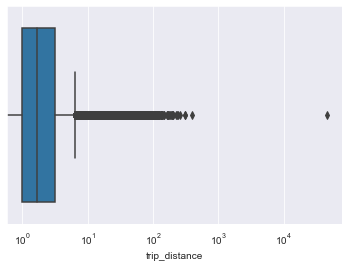

In [12]:
sns.set_style('darkgrid')
ax = sns.boxplot(x=full_taxi_data_df['trip_distance'])
ax.set(xscale="log")
plt.savefig('figures/distance_pre_box.png')

In [13]:
# trip_distance - remove outliers (0.001 quantile)

print(full_taxi_data_df['trip_distance'].describe())

distance_cutoff = full_taxi_data_df['trip_distance'].quantile(.999)
invalid_distance = full_taxi_data_df[(full_taxi_data_df['trip_distance'] > distance_cutoff) | (full_taxi_data_df['trip_distance'] < 0)].index
full_taxi_data_df.drop(invalid_distance, inplace=True)

print(full_taxi_data_df.shape)

count    2.066070e+07
mean     3.058372e+00
std      1.085819e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.690000e+00
75%      3.140000e+00
max      4.597722e+04
Name: trip_distance, dtype: float64
(20593124, 11)


In [14]:
# RatecodeID 
# only be using standard and JFK
VALID_RATECODES = [1,2]

print(full_taxi_data_df['RatecodeID'].value_counts())
invalid_ratecodes = full_taxi_data_df[~full_taxi_data_df['RatecodeID'].isin(VALID_RATECODES)].index
full_taxi_data_df.drop(invalid_ratecodes, inplace=True)
full_taxi_data_df.drop(['RatecodeID'], axis=1, inplace=True)

print(full_taxi_data_df.shape)

1.0     19880374
2.0       547958
5.0       106611
3.0        43457
4.0        13862
99.0         797
6.0           65
Name: RatecodeID, dtype: int64
(20020332, 10)


In [15]:
# LocationID - only take those in shapefile that are valid (1 - 263)

VALID_LOCATIONS = list(range(1,264))
invalid_pickups = full_taxi_data_df[~full_taxi_data_df['PULocationID'].isin(VALID_LOCATIONS)].index
full_taxi_data_df.drop(invalid_pickups, inplace=True)
invalid_dropoffs = full_taxi_data_df[~full_taxi_data_df['DOLocationID'].isin(VALID_LOCATIONS)].index
full_taxi_data_df.drop(invalid_dropoffs, inplace=True)

print(full_taxi_data_df.shape)

(19411591, 10)


In [16]:
# fare_amount

# drop all negatives
print(full_taxi_data_df['fare_amount'].describe())
negative_fare = full_taxi_data_df[(full_taxi_data_df['fare_amount'] < 0)].index
full_taxi_data_df.drop(negative_fare, inplace=True)

print(full_taxi_data_df.shape)

count    1.941159e+07
mean     1.310409e+01
std      7.950571e+01
min     -1.580000e+02
25%      6.500000e+00
50%      9.500000e+00
75%      1.500000e+01
max      3.469500e+05
Name: fare_amount, dtype: float64
(19400470, 10)


In [17]:
# total_amount - only take positive
print(full_taxi_data_df['total_amount'].describe())
negative_total = full_taxi_data_df[(full_taxi_data_df['total_amount'] < 0)].index
full_taxi_data_df.drop(negative_total, inplace=True)

print(full_taxi_data_df.shape)

count    1.940047e+07
mean     1.895463e+01
std      7.994077e+01
min      0.000000e+00
25%      1.130000e+01
50%      1.476000e+01
75%      2.076000e+01
max      3.470350e+05
Name: total_amount, dtype: float64
(19400470, 10)


In [18]:
# payment_type - only take trips paid with cash as tips are more accurate

VALID_PAYMENT_TYPE = 1
print(full_taxi_data_df['payment_type'].value_counts())
full_taxi_data_df = full_taxi_data_df[full_taxi_data_df.payment_type == VALID_PAYMENT_TYPE]
full_taxi_data_df.drop(['payment_type'], axis=1, inplace=True)

1.0    13832285
2.0     5568185
Name: payment_type, dtype: int64


In [19]:
# our shape after removing 'invalid' rows
full_taxi_data_df.shape

(13832285, 9)

In [22]:
# connect column 'profit' 

def get_trip_duration(pickup_datetime, dropoff_datetime):
    '''
    Returns the duration in minutes of a trip, given a pickup and dropoff datetime

            Parameters:
                    pickup_datetime (Timestamp): Pick up datetime
                    dropoff_datetime (Timestamp): Drop off up datetime

            Returns:
                    trip_duration (float): duration in minutes
    '''
    time_diff = dropoff_datetime - pickup_datetime
    return (time_diff.seconds)//60


In [23]:
# get every trip's duration
full_taxi_data_df['trip_duration'] = full_taxi_data_df.apply(lambda x: get_trip_duration(x['pickup_datetime'], x['dropoff_datetime']), axis=1)


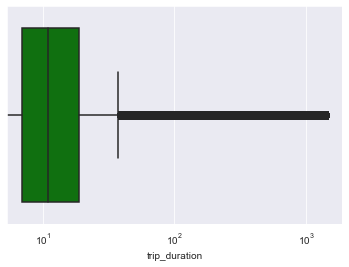

In [24]:
sns.set_style('darkgrid')
ax = sns.boxplot(x=full_taxi_data_df['trip_duration'], color='green')
ax.set(xscale="log")
plt.savefig('figures/duration_pre_box.png')

In [26]:
# trip_duration - remove trips over 2.5h hrs

print(full_taxi_data_df['trip_duration'].describe())
duration_cutoff = 150
invalid_duration = full_taxi_data_df[(full_taxi_data_df['trip_duration'] > duration_cutoff) | (full_taxi_data_df['trip_distance'] < 0)].index
print(len(invalid_duration))
full_taxi_data_df.drop(invalid_duration, inplace=True)

count    1.383228e+07
mean     1.803399e+01
std      6.961989e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.900000e+01
max      1.439000e+03
Name: trip_duration, dtype: float64
35542


In [27]:
# dont need these columns

full_taxi_data_df.drop(['fare_amount'], axis=1, inplace=True)
full_taxi_data_df.drop(['tip_amount'], axis=1, inplace=True)

In [25]:
def get_hour(time):
    '''
    Rounds a datetime to an hour

            Parameters:
                    time (Timestamp): Any datetime

            Returns:
                    time_hour (str): hour of input datetime
    '''
    pu_datetime = datetime.fromisoformat(str(time))
    return pu_datetime.strftime('%H:00')

In [29]:
# get the hour a trip started and finished
full_taxi_data_df['pu_hour'] = full_taxi_data_df.apply(lambda x: get_hour(x['pickup_datetime']), axis=1)
full_taxi_data_df['do_hour'] = full_taxi_data_df.apply(lambda x: get_hour(x['dropoff_datetime']), axis=1)

In [30]:
# get taxi demand in a given zone

# number of trips in dataset per zone per hour
hour_demand_df = full_taxi_data_df.groupby(['PULocationID', 'pu_hour']).size().reset_index()
hour_demand_df.rename(columns={0: 'count'}, inplace=True)

In [31]:
# get an ID for each zone/hour combo
zone_demand_keys = []
for index,row in hour_demand_df.iterrows():
    zone_demand_keys.append(str(row['PULocationID']) +'-'+ str(row['pu_hour']))

In [32]:
# create a dict giving the number of trips per zone per hour in the data set
hour_demand_df['zone_demand_key'] = np.array(zone_demand_keys)
zone_demand_dict = hour_demand_df.set_index("zone_demand_key")["count"].to_dict()

In [33]:
DAYS_IN_DATASET = 92
def get_hourly_zone_demand(zone_demand_dict, PULocationID, pu_hour):
    '''
    Returns average number of trips per zone per day per hour

            Parameters:
                    zone_demand_dict (): A dictionary storing the hourly zone demand for each zone/hour combination
                    PULocationID (int): 
                    pu_hour (): 

            Returns:
                    time_hour ((pandas._libs.tslibs.timestamps.Timestamp)): duration in minutes
    '''
    demand_key = str(PULocationID) +'-'+ str(pu_hour)

    # 1/92 is the base demand figure, so we need to add one to every existing demand figure
    if demand_key in zone_demand_dict.keys():
        return (zone_demand_dict[demand_key]+ 1) / DAYS_IN_DATASET
    else:
        return 1/DAYS_IN_DATASET


In [34]:
# attach hourly demand figure for each trip, given its zone and pick up hour

full_taxi_data_df['pu_zone_hourly_demand'] = full_taxi_data_df.apply(lambda x: get_hourly_zone_demand(zone_demand_dict, x['PULocationID'], x['pu_hour']), axis=1)
full_taxi_data_df['do_zone_hourly_demand'] = full_taxi_data_df.apply(lambda x: get_hourly_zone_demand(zone_demand_dict, x['DOLocationID'], x['do_hour']), axis=1)

In [28]:
# profit rate of a given trip

CPM = 0.58 # cost per mile
MINS_IN_HOUR = 60

def get_trip_rate(total_amount, trip_distance, trip_duration, pu_zone_hourly_demand, drop_off_zone_hourly_demand):
    '''
    The profit rate of a given trip, calculated by the metric seen in equation (1) in report

            Parameters:
                    total_amount (float): cost of the trip in USD
                    trip_distance (float): distance of the trip in miles
                    trip_duration (float): duration of the trip in minutes
                    pu_zone_hourly_demand (float): hourly demand of pickup zone
                    drop_off_zone_hourly_demand (float): hourly demand of drop off zone

            Returns:
                    trip_rate (float): profit rate of a trip
    '''
    if trip_duration == 0:
        return 0
    return ((MINS_IN_HOUR*(total_amount - CPM * trip_distance))/(trip_duration) * pu_zone_hourly_demand * drop_off_zone_hourly_demand)

In [35]:
# get profit rate of trip for each row in data set
full_taxi_data_df['trip_profit_rate'] = full_taxi_data_df.apply(lambda x: get_trip_rate(x['total_amount'], x['trip_distance'], x['trip_duration'], x['pu_zone_hourly_demand'], x['do_zone_hourly_demand']), axis=1)

In [36]:
# split into three equal bins

def classify_profitability(x, low_limit, high_limit):
    '''
    Bins the profitability into three equal frequency bins

            Parameters:
                    x (float): profitability figure
                    low_limit (float): lower tertile
                    high_limit (float): upper tertile

            Returns:
                    bin (int): profitability label (1 for low, 2 for medium, 3 for high)
    '''
    if x < low_limit.values[0]:
        return 1
    elif x > high_limit.values[0]:
        return 3
    else:
        return 2

In [37]:
# we want equal frequency bins for set the lower tertile and upper tertile accordingly
low_limit = full_taxi_data_df['trip_profit_rate'].quantile([1/3])
high_limit = full_taxi_data_df['trip_profit_rate'].quantile([2/3])

In [38]:
# give each trip a profit label and set it as categorical variable
full_taxi_data_df['profit_label'] = full_taxi_data_df.apply(lambda x: classify_profitability(x['trip_profit_rate'],low_limit, high_limit), axis=1)
full_taxi_data_df['profit_label'] = full_taxi_data_df.profit_label.astype('category')

In [39]:
# save our results
full_taxi_data_df.to_csv('processed_data/full_taxi_data_df_clean.csv', index=False)